In [11]:
import pandas as pd
import re
import time
import datetime

In [12]:

# lhidde: Fix for my machine to machine times new roman not bold.
import matplotlib
import matplotlib.pyplot as plt
# del matplotlib.font_manager.weight_dict['roman']
# matplotlib.font_manager._rebuild()

## Loading data

In [13]:
import plots.e2e_parse_benchlog as parser
import os

# e2e_base_dir = "./../rofl_polybox_data/" # for nicolas

# e2e_base_dir = "/Users/hidde/PhD/fl/fl-ansible/experiment_results/e2e/" # for hidde
e2e_base_dir = "./data/endtoend/" # for hidde

configs = {
    # Shakespeare
#     os.path.join(e2e_base_dir, "shakespeare_e2e_1642508379/linf_extrapolate"): {
#         "dataset": "Shakespeare",
#         "type": "linf",
#         "version": "unoptimized",
#         "bandwidth": 0.00
#     },
#     os.path.join(e2e_base_dir, "shakespeare_e2e_1642508379/l2_extrapolate"): {
#         "dataset": "Shakespeare",
#         "type": "l2",
#         "version": "unoptimized",
#         "bandwidth": 0.00
#     },
    os.path.join(e2e_base_dir, "shakespeare_e2e_1642508379/1"): {
        "dataset": "Shakespeare",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 153.91
    },
    os.path.join(e2e_base_dir, "shakespeare_e2e_1642508379/0"): {
        "dataset": "Shakespeare",
        "type": "plain",
        "version": "None",
        "bandwidth": 6.3
    },
    # CIFAR Large
    os.path.join(e2e_base_dir, "cifar_large_1631562777/l2_rsl"): {
        "dataset": "CIFAR Large",
        "type": "l2_opt",
        "version": "optimized",
        "bandwidth": 89.83
    },
    os.path.join(e2e_base_dir, "cifar_large_1631562777/1"): {
        "dataset": "CIFAR Large",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 411.16
    },
    os.path.join(e2e_base_dir, "cifar_large_1631562777/0"): {
        "dataset": "CIFAR Large",
        "type": "plain",
        "version": "None",
        "bandwidth": 16.89
    },
#     os.path.join(e2e_base_dir, "cifar_large_1631562777/l2_extrapolate"): {
#         "dataset": "CIFAR Large",
#         "type": "l2",
#         "version": "unoptimized",
#         "bandwidth": 0.00
#     },

    os.path.join(e2e_base_dir, "cifar_small_1631607104/0"): {
        "dataset": "CIFAR Small",
        "type": "l2_opt",
        "version": "optimized",
        "bandwidth": 16.9
    },
    os.path.join(e2e_base_dir, "cifar_small_1631607104/3"): {
        "dataset": "CIFAR Small",
        "type": "l2",
        "version": "unoptimized",
        "bandwidth": 86.99
    },
    os.path.join(e2e_base_dir, "cifar_small_1631607104/1"): {
        "dataset": "CIFAR Small",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 58.41
    },
    os.path.join(e2e_base_dir, "cifar_small_1631607104/4"): {
        "dataset": "CIFAR Small",
        "type": "linf",
        "version": "unoptimized",
        "bandwidth": 58.41
    },
    os.path.join(e2e_base_dir, "cifar_small_1631607104/2"): {
        "dataset": "CIFAR Small",
        "type": "plain",
        "version": None,
        "bandwidth": 2.45
    },

    # CIFAR Small L2
    # MNIST Linf, L2
    os.path.join(e2e_base_dir, "mnist_e2e_1631611383/1"): {
        "dataset": "MNIST",
        "type": "l2_opt",
        "version": "optimized",
        "bandwidth": 11.34
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1631611383/2"): {
        "dataset": "MNIST",
        "type": "l2",
        "version": "unoptimized",
        "bandwidth": 43.11
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1631611383/3"): {
        "dataset": "MNIST",
        "type": "linf_opt",
        "version": "optimized",
        "bandwidth": 28.98
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1631611383/4"): {
        "dataset": "MNIST",
        "type": "linf",
        "version": "unoptimized",
        "bandwidth": 28.98
    },
    os.path.join(e2e_base_dir, "mnist_e2e_1631611383/0"): {
        "dataset": "MNIST",
        "type": "plain",
        "version": None,
        "bandwidth": 1.3
    }
}

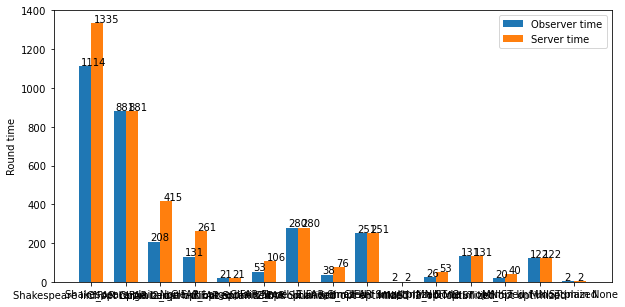

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = [f"{config['dataset']} {config['type']} {config['version']}" for _, config in configs.items()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

data_server, observer_data, client_data = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, (path, config) in enumerate(configs.items()):
    s, o, clients = parser.load_benchlog(path)

    for v in [s, o, clients]:
        idf = f"{config['dataset']} {config['type']} {config['version']}"
        v["idf"] = idf
        for key in ['dataset', 'type', 'version', 'bandwidth']:
            v[key] = config[key]

    o["rel_time"] = o['time'].diff().dt.total_seconds()
    o["rel_time"] = o["rel_time"][1:]

    data_server = data_server.append(s)
    observer_data = observer_data.append(o)
    client_data = client_data.append(clients)

# display(observer_data)
pd.set_option('display.max_rows', 500)

fig, ax = plt.subplots(figsize=[10, 5])

# x = observer_data.groupby(["idf"])["time"].diff().dt.total_seconds()

# observer_data["rel_time"] = observer_data['time'].diff().dt.total_seconds()
# observer_data[observer_data["round"] == 0]["rel_time"] = None

# display(observer_data)
# display(observer_data.groupby(["idf"])["rel_time"].mean())

y1 = observer_data.groupby(["idf"], sort=False)["rel_time"].mean()
y2 = data_server.groupby(["idf"], sort=False)["verification_complete"].mean() / 1000
rects1 = ax.bar(x - width/2, y1, width, label='Observer time')
rects2 = ax.bar(x + width/2, y2, width, label='Server time')

# display(y1)
# display(y2)

ax.set_ylabel("Round time")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
for a, (b, c) in zip(x, zip(y1, y2)):
    ax.text(a - width / 1.2, b + 5, round(b), color='black')
    ax.text(a + width / 4, c + 5, round(c), color='black')

# plt.show()
plt.savefig("plots_output/e2e_cifar_linf.png")

# data_server.to_csv("")

In [15]:
# Server benchlor

results = data_server.groupby(["dataset", "type"]).agg({'verification_complete': ['sum', 'mean', 'sem']})
results.reset_index()
results_per_dataset = results.groupby("dataset")
# print(results_per_dataset)

in_group = results['verification_complete']['mean']\
    .groupby(["dataset"])\
    .transform(lambda x: x / x[x.index.get_level_values('type') == 'plain'][0])
# results['fraction'] = results['verification_complete']['mean'] / results[results['type'] == 'plain']['verification_complete']['mean']

in_group = in_group.rename('mean_factor')

results = results.join(in_group, on=['dataset', 'type'])
results['mean_factor'] = results['mean_factor'].round(2)
display(results)

/Users/hidde/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(verification_complete, sum)  \
dataset     type                                     
CIFAR Large l2_opt                        66037768   
            linf_opt                      41441169   
            plain                          3393309   
CIFAR Small l2                            28020906   
            l2_opt                        10538221   
            linf                          25125263   
            linf_opt                       7518343   
            plain                           183188   
MNIST       l2                            20965718   
            l2_opt                         8355927   
            linf                          19500297   
            linf_opt                       6281259   
            plain                           335117   
Shakespeare linf_opt                      25362079   
            plain                         17628818   

                      (verification_complete, mean)  \
dataset     type                                      
CIFAR Large l2_opt                     4.153319e+05   
            linf_opt                   2.606363e+05   
            plain                      2.120818e+04   
CIFAR Small l2                         2.802091e+05   
            l2_opt                     1.064467e+05   
            linf                       2.512526e+05   
            linf_opt                   7.594286e+04   
            plain                      1.831880e+03   
MNIST       l2                         1.310357e+05   
            l2_opt                     5.255300e+04   
            linf                       1.218769e+05   
            linf_opt                   3.950477e+04   
            plain                      2.094481e+03   
Shakespeare linf_opt                   1.334846e+06   
            plain                      8.814409e+05   

                      (verification_complete, sem)  mean_factor  
dataset     type                                                 
CIFAR Large l2_opt                      500.195291        19.58  
            linf_opt                    387.689467        12.29  
            plain                        16.405183         1.00  
CIFAR Small l2                          777.535586       152.96  
            l2_opt                      321.606864        58.11  
            linf                        782.665242       137.16  
            linf_opt                    275.507924        41.46  
            plain                         6.842208         1.00  
MNIST       l2                          279.224816        62.56  
            l2_opt                       74.427940        25.09  
            linf                        231.921758        58.19  
            linf_opt                     76.199265        18.86  
            plain                         3.824727         1.00  
Shakespeare linf_opt                   5567.791167         1.51  
            plain                       215.580610         1.00

In [16]:
observer_results = observer_data.groupby(["dataset", "type"]).agg({'rel_time': ['sum', 'mean', 'sem'], 'acc': lambda x: x.iloc[-1], 'loss': ['min'], 'bandwidth': 'mean'})
in_group = observer_results['rel_time']['mean']\
    .groupby(["dataset"])\
    .transform(lambda x: x / x[x.index.get_level_values('type') == 'plain'][0])
in_group = in_group.rename('mean_factor')
observer_results = observer_results.join(in_group, on=['dataset', 'type'])
observer_results['mean_factor'] = observer_results["mean_factor"].round(2)

in_group = observer_results[('bandwidth', 'mean')]\
    .groupby(["dataset"])\
    .transform(lambda x: x / x[x.index.get_level_values('type') == 'plain'][0])
in_group = in_group.rename('bw_factor')
observer_results = observer_results.join(in_group, on=['dataset', 'type'])
observer_results['bw_factor'] = observer_results["bw_factor"].round(0)

display(observer_results)

/Users/hidde/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(rel_time, sum)  (rel_time, mean)  (rel_time, sem)  \
dataset     type                                                           
CIFAR Large l2_opt          33046.195        207.837704         0.853009   
            linf_opt        20775.455        130.663239         0.372273   
            plain            3371.535         21.204623         0.012393   
CIFAR Small l2              27736.781        280.169505         0.783669   
            l2_opt           5264.062         53.172343         0.229647   
            linf            24875.766        251.270364         0.789093   
            linf_opt         3756.275         37.942172         0.180173   
            plain             181.183          1.830131         0.004931   
MNIST       l2              20838.586        131.060289         0.279476   
            l2_opt           4176.917         26.269918         0.108175   
            linf            19383.740        121.910314         0.230659   
            linf_opt         3142.105         19.761667         0.135059   
            plain             332.842          2.093346         0.002442   
Shakespeare linf_opt        21161.588       1113.767789        12.711974   
            plain           16746.955        881.418684         0.185946   

                      (acc, <lambda>)  (loss, min)  (bandwidth, mean)  \
dataset     type                                                        
CIFAR Large l2_opt           0.816800     0.541361              89.83   
            linf_opt         0.847800     0.596150             411.16   
            plain            0.860500     0.553629              16.89   
CIFAR Small l2               0.603300     1.124369              86.99   
            l2_opt           0.584000     1.172460              16.90   
            linf             0.603800     1.126371              58.41   
            linf_opt         0.604500     1.123299              58.41   
            plain            0.605800     1.122183               2.45   
MNIST       l2               0.985400     0.074744              43.11   
            l2_opt           0.974100     0.115891              11.34   
            linf             0.987300     0.073370              28.98   
            linf_opt         0.985400     0.072486              28.98   
            plain            0.987300     0.071346               1.30   
Shakespeare linf_opt         0.571476     1.400858             153.91   
            plain            0.571504     1.398075               6.30   

                      mean_factor  bw_factor  
dataset     type                              
CIFAR Large l2_opt           9.80        5.0  
            linf_opt         6.16       24.0  
            plain            1.00        1.0  
CIFAR Small l2             153.09       36.0  
            l2_opt          29.05        7.0  
            linf           137.30       24.0  
            linf_opt        20.73       24.0  
            plain            1.00        1.0  
MNIST       l2              62.61       33.0  
            l2_opt          12.55        9.0  
            linf            58.24       22.0  
            linf_opt         9.44       22.0  
            plain            1.00        1.0  
Shakespeare linf_opt         1.26       24.0  
            plain            1.00        1.0

In [17]:
display(observer_data[(observer_data["dataset"] == "Shakespeare") & (observer_data["type"] == "l2")]["rel_time"])

Series([], Name: rel_time, dtype: float64)

In [18]:

# output
cols = [('acc', '<lambda>'), ('rel_time', 'mean'), ('rel_time', 'sum'), ('bandwidth', 'mean'), 'mean_factor', 'bw_factor']

output_frame = pd.DataFrame()
output_frame[['acc', 'mean_s', 'sum_s', 'bandwidth_GB', 'mean_factor', 'bw_factor']] = observer_results[cols]
output_frame['mean_factor'] = output_frame['mean_factor'].round(2).astype(np.float32)
output_frame['bw_factor'] = output_frame['bw_factor'].round(0).astype(np.int32)

# Server terminates at round id 39.
output_frame['sum_s'] = output_frame['sum_s'] + output_frame['mean_s']

#str(round(x, 2)))
display(output_frame)

output_frame.to_csv("data/e2e_table.csv")

/Users/hidde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


acc       mean_s         sum_s  bandwidth_GB  \
dataset     type                                                          
CIFAR Large l2_opt    0.816800   207.837704  33254.032704         89.83   
            linf_opt  0.847800   130.663239  20906.118239        411.16   
            plain     0.860500    21.204623   3392.739623         16.89   
CIFAR Small l2        0.603300   280.169505  28016.950505         86.99   
            l2_opt    0.584000    53.172343   5317.234343         16.90   
            linf      0.603800   251.270364  25127.036364         58.41   
            linf_opt  0.604500    37.942172   3794.217172         58.41   
            plain     0.605800     1.830131    183.013131          2.45   
MNIST       l2        0.985400   131.060289  20969.646289         43.11   
            l2_opt    0.974100    26.269918   4203.186918         11.34   
            linf      0.987300   121.910314  19505.650314         28.98   
            linf_opt  0.985400    19.761667   3161.866667         28.98   
            plain     0.987300     2.093346    334.935346          1.30   
Shakespeare linf_opt  0.571476  1113.767789  22275.355789        153.91   
            plain     0.571504   881.418684  17628.373684          6.30   

                      mean_factor  bw_factor  
dataset     type                              
CIFAR Large l2_opt       9.800000          5  
            linf_opt     6.160000         24  
            plain        1.000000          1  
CIFAR Small l2         153.089996         36  
            l2_opt      29.049999          7  
            linf       137.300003         24  
            linf_opt    20.730000         24  
            plain        1.000000          1  
MNIST       l2          62.610001         33  
            l2_opt      12.550000          9  
            linf        58.240002         22  
            linf_opt     9.440000         22  
            plain        1.000000          1  
Shakespeare linf_opt     1.260000         24  
            plain        1.000000          1

### Accuracy plot

In [19]:
def _preprocess(df, suffix):
    # set start timestamp to 0 (1 because of x-axis log scale)
    df["rel_time"].iloc[0] = 1
    df["cumtime"] = df["rel_time"].cumsum()
    df = df.rename(columns={"accuracy": f"accuracy_{suffix}", "rel_time": f"rel_time_{suffix}", "cumtime": f"cumtime_{suffix}" })
    return df

def _select_df(df, idf):
    plot_data = pd.DataFrame()
    plot_data[['round', 'accuracy', 'rel_time']] = df[df['idf'] == idf] \
        [['round', 'acc', 'rel_time']]
    return plot_data

CIFAR Large

In [20]:
from plots.e2e_time import build_fig_e2e_cifar_time
from functools import reduce

df_u = _preprocess(_select_df(observer_data, "CIFAR Large plain None"), "u")
df_l8p = _preprocess(_select_df(observer_data, "CIFAR Large linf_opt optimized"), "l8p")

data_frames = [df_u, df_l8p]
df = reduce(lambda  left, right: pd.merge(left, right, on=['round'], how='outer'), data_frames)
fig_e2e_cifar_time = build_fig_e2e_cifar_time(df)
display(fig_e2e_cifar_time)

ModuleNotFoundError: No module named 'pymongo'

Shakespeare

In [ ]:
from plots.e2e_time import build_fig_e2e_shakespeare_time

df_u = _preprocess(_select_df(observer_data, "Shakespeare plain None"), "u")
df_l8p = _preprocess(_select_df(observer_data, "Shakespeare linf_opt optimized"), "l8p")

data_frames = [df_u, df_l8p]
df = reduce(lambda  left, right: pd.merge(left, right, on=['round'], how='outer'), data_frames)
fig_e2e_cifar_time = build_fig_e2e_shakespeare_time(df)
display(fig_e2e_cifar_time)
# display(df)

In [ ]:
from plots.e2e_time import build_fig_e2e_mnist_time
from functools import reduce

df_u = _preprocess(_select_df(observer_data, "MNIST plain None"), "u")
# display(df_u)
# display(observer_data)
df_l8 = _preprocess(_select_df(observer_data, "MNIST linf unoptimized"), "l8")
df_l8p = _preprocess(_select_df(observer_data, "MNIST linf_opt optimized"), "l8p")
df_l2 = _preprocess(_select_df(observer_data, "MNIST l2 unoptimized"), "l2")
df_l2rst = _preprocess(_select_df(observer_data, "MNIST l2_opt optimized"), "l2rst")
#
data_frames = [df_u, df_l8, df_l8p, df_l2, df_l2rst]
df = reduce(lambda  left, right: pd.merge(left, right, on=['round'], how='outer'), data_frames)
fig_e2e_mnist_time = build_fig_e2e_mnist_time(df)
display(fig_e2e_mnist_time)

# display(df)

### Timing plot

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

# display(data_server)

from matplotlib import cm

records = [
    "MNIST linf_opt optimized",
    "CIFAR Small linf_opt optimized",
    "CIFAR Large linf_opt optimized",
    "Shakespeare linf_opt optimized"
]
metadata = {
           "CIFAR Large linf_opt optimized": { "label": "CIFAR-10 L" },
           "CIFAR Small linf_opt optimized": { "label": "CIFAR-10 S" },
           "MNIST linf_opt optimized": { "label": "MNIST" },
           "Shakespeare linf_opt optimized": { "label": "Shakespeare" },
    }

columns_server = [
    # 'start',
                  "agg_done", "param_extraction_done"] #, "verification_complete"]
columns_client = ["model_download", "model_training",
                       "model_crypto", "model_upload"]
metadata_columns = {
    'start': "Training time",
    'agg_done': "Reconstruction",
    'param_extraction_done': 'Verification time',
    'model_download': 'Model download',
    'model_training': 'Training time',
    'model_crypto': 'Proof creation',
    'model_upload': 'Model upload'
}

client_colors = [cm.get_cmap("Blues")(col) for col in np.linspace(0.4, 0.8, len(columns_client))]
server_colors = [cm.get_cmap("Greens")(col) for col in np.linspace(0.4, 0.7, len(columns_server))]
bar_colors = client_colors + server_colors

In [ ]:
client_colors = [cm.get_cmap("Blues")(col) for col in np.linspace(0.0, 0.4, len(columns_client))]
server_colors = [cm.get_cmap("Greens")(col) for col in np.linspace(0.1, 0.4, len(columns_server))]
bar_colors_non_current = client_colors + server_colors


In [ ]:
# transform data into df1 (which contains the required format

data_df_server = data_server.groupby("idf")[columns_server].mean()
data_df_client = client_data.groupby("idf")[columns_client].max()
df1 = data_df_client.loc[records]
df1_server = data_df_server.loc[records]

# combine model download and training into training time (i.e., what it would be on plaintext)
df1["training"] = df1["model_download"] + df1["model_training"]

# sum creating proofs (well formedness + range proof), model upload time + discrete log solve time
df1["createproof"] = df1["model_crypto"] + df1["model_upload"] + df1_server["agg_done"]

# overhead for verifying proofs
df1["verifyproof"] = df1_server["param_extraction_done"]

df1 = df1[["training", "createproof", "verifyproof"]]

print(f"df1: ")
display(df1)

total_sum = (df1["verifyproof"] - df1.sum(axis=1)) / df1.sum(axis=1)
display(total_sum)
display("The above is not valid for shakespeare, because verifyproof only is not dictating the new time!")

# scale the numbers such that 3* verify == 100%
df1_scaled = pd.DataFrame()

# scale either by verifyproof or by sum of training and createproof
max_series = pd.concat([df1["verifyproof"], df1["training"] + df1["createproof"]], axis=1).max(axis=1)

def determine_scale(row):
    if row["training"] + row["createproof"] > row["verifyproof"]:
        base = 2 * (row["training"] + row["createproof"])
        return (base + row["verifyproof"])
    else:
        return row["verifyproof"] * 3

# scale each column such that 3*max_series column is 100%
df1["scale"] = df1.apply(determine_scale, axis=1)

for col in df1.columns.values: 
    df1_scaled[col] = df1[col] * 100 / df1["scale"]
print(f"\ndf1_scaled: ")
display(df1_scaled)


# mark for which phase (create, train, verify) we have data from a particular round
verifyproof_rounds = ["t-1", "t", "t+1"]
createproof_rounds = ["t", "t+1", "t+2"]
training_rounds = ["t", "t+1", "t+2"]

per_round_offset = 100.0 / 3.0

with PdfPages(f"plots_output/e2e_operation_times_optimistic_cont_nku.pdf") as pdf:
    fig, ax = plt.subplots(figsize=(7,4))
    y_pos = np.arange(len(records))

    bar_height = 0.3

    from common import get_colorful_styles

    colors, linestyles = get_colorful_styles()

    color_d = {
        "t-1": (0.66, 0.66, 0.66, 1),
        "t": colors[2],
        "t+1": colors[1],
        "t+2": (0.44, 0.44, 0.44, 1),
    }


    bars = []

    for i, round_lbl in enumerate(["t-1", "t", "t+1", "t+2"]):
        
        per_round_offset = pd.concat([df1_scaled["verifyproof"], df1_scaled["training"] + df1_scaled["createproof"]], axis=1).max(axis=1)
        
#         if i is 0:
#             current_round_offset = 0
#         else:
#             max_series = pd.concat([df1["verifyproof"], df1["training"] + df1["createproof"]], axis=1).max(axis=1)

#             current_round_offset = df1_scaled["verifyproof"]
    
        if round_lbl in verifyproof_rounds:
            # add the horizontal bars for verify (3rd lines)
            rects = ax.barh(y_pos - bar_height, left=i * per_round_offset, width=df1_scaled["verifyproof"], height=bar_height, color=color_d[round_lbl], label=f"{round_lbl}", edgecolor="black")
    
            if round_lbl == "t":
                bars += [(bar, "verify") for bar in rects]
            
    
        if round_lbl in training_rounds:
            # add the horizontal bars for train model (1st lines)
            label = f"{round_lbl}" if round_lbl not in verifyproof_rounds else None
            left = (i-1) * per_round_offset
            rects = ax.barh(y_pos + bar_height, left=left, width=df1_scaled["training"], height=bar_height, color=color_d[round_lbl], label=label, edgecolor="black")
        
            if round_lbl == "t":
                bars += [(bar, "train") for bar in rects]
    
        if round_lbl in createproof_rounds:
            # add the horizontal bars for create proofs (2nd lines)
            left = (i-1) * per_round_offset + df1_scaled["training"]
            rects = ax.barh(y_pos, left=left, width=df1_scaled["createproof"], height=bar_height, color=color_d[round_lbl], label=None, edgecolor="black")
        
            if round_lbl == "t":
                bars += [(bar, "create") for bar in rects]

            
    # set minor tick labels: which phase it is (train, create, verify)
    ax.set_yticks([bar.get_y() + bar.get_height() / 2 + 0.0001 for bar, _ in bars], minor=True)        
    ax.set_yticklabels([label for _, label in bars], minor=True, va="center")
    for tick in ax.yaxis.get_minor_ticks():
        tick.label.set_fontsize(16)

    # set major tick labels: which model is used
    major_label_d = {
        "CIFAR Large linf_opt optimized": "C10-L",
        "CIFAR Small linf_opt optimized": "C10-S",
        "MNIST linf_opt optimized": "FMN",
        "Shakespeare linf_opt optimized": "SHK",
    }

    # the pad controls the distance between modeles (e.g., C10-L) and phase names (e.g., train)
    ax.tick_params(axis='y', which='major', pad=45, size=0)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([major_label_d[key]for key in records], rotation = 90, va="center")
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

    ax.set_xlabel("Round t and t+1 Progress [%]")
    ax.set_xlim(0, 100)

    #ax.legend(ncol=4, bbox_to_anchor=(-0.48, 1), loc='lower left', fontsize='small')
    
    ax.legend(ncol=1, bbox_to_anchor=(1, 0), loc='lower left', fontsize='small',  handlelength=0.7)
    
    pdf.savefig(bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
savings = pd.DataFrame()
savings["new_round_time"] = pd.concat([df1_scaled["verifyproof"], df1_scaled["training"] + df1_scaled["createproof"]], axis=1).max(axis=1)
display(savings["new_round_time"])
savings["old_round_time"] = df1_scaled["training"] + df1_scaled["createproof"] + df1_scaled["verifyproof"]
savings["percent_reduction"] = round(-100 * (savings["new_round_time"] - savings["old_round_time"]) / savings["old_round_time"], 2)
display(savings)

# Probabilistic Checking

In [ ]:
# Probabilistic Checking
from plots.probabilistic_checking import build_prob_checking_data, build_fig_pcheck_num_required_checks
lines = build_prob_checking_data()

fig_pcheck_num_required_checks = build_fig_pcheck_num_required_checks(lines)

print("Probabilistic Checking:")
display(fig_pcheck_num_required_checks)

# print data
for line in lines:
    print(f"fail_prob_bound={line['fail_prob_bound']} \t prob_weights_violating_bound={line['prob_weights_violating_bound']}")

    lst = [(label, value) for label, value in zip(line["labels (n_weights)"], line["values (n_checks)"])]
    
    print(f"(n_weights, n_checks): {lst}")
    print("====================\n")

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from plots.probabilistic_checking import detection_prop_hypergeometric

df = pd.DataFrame(columns=['p_c', 'detection_rate'])
num_samples = 500

for task, mal_update_size, mal_update_outside_bound in zip(["FMN", "C10"], [44426, 274442], [36320, 224607]):

    mal_update = np.zeros([mal_update_size], dtype=np.bool)
    mal_update[:mal_update_outside_bound] = True
    mal_update = np.random.permutation(mal_update)

    p_cs = np.arange(0.00001, 0.001, 0.00001)
    # print(p_cs)

    for p_c in tqdm(p_cs,):
        # we select p_c at random
        num_select = int(mal_update_size * p_c)
    #     print(f"Selecting {num_select}")
        hits = 0
        computed = detection_prop_hypergeometric(mal_update_size, mal_update_outside_bound, num_select)
    #     print(computed)
        for i in range(num_samples):
            selection_indices = np.random.choice(mal_update_size, num_select, replace=False)
            if np.any(mal_update[selection_indices]) == True:
                hits += 1

        std_array = np.zeros(num_samples)
        std_array[:hits] = 1
        std = np.std(std_array)
        df = df.append({
            'p_c': p_c,
            'detection_rate': float(hits) / float(num_samples),
            'std': std,
            'computed': computed,
            'task': task
        }, ignore_index=True)

display(df)

In [ ]:
from plots.e2e_time import setup_plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

from common import output_dir, get_colorful_styles
setup_plt()

name="pcheck_real_vector_detection"
colors, _ = get_colorful_styles()

# compute where filter probability is at least 1e-08
task_colors = {
    "FMN": colors[1],
    "C10": colors[2]
}


# display(df)
# display(error_rate1e8)
with PdfPages(f"{output_dir}/{name}.pdf") as pdf:

    fig, ax = plt.subplots()

    ##########################
    # Draw all the lines
    ##########################

    # lineplot
    for task in ["FMN", "C10"]:
        df_t = df[df["task"] == task]
#         plt.errorbar(df_t["p_c"], df_t["detection_rate"], yerr=df_t["std"]/10.0, label=f"{task}-P", color=task_colors[task])
        plt.plot(df_t["p_c"], df_t["computed"], label=f"{task}-P", color=colors[3])

    
        target = 1-1e-08
        error_rate1e8 = df_t[df_t["computed"] >= target].nsmallest(1, "computed")

        target = 1-1e-06
        error_rate1e6 = df_t[df_t["computed"] >= target].nsmallest(1, "computed")
        
        label = None
        if task == "FMN":
            plt.scatter(error_rate1e8["p_c"], error_rate1e8["computed"], label="$\\delta=1e-08$", color=colors[3])
            plt.scatter(error_rate1e6["p_c"], error_rate1e6["computed"], label="$\\delta=1e-06$", color=colors[4])
        else:
            plt.scatter(error_rate1e8["p_c"], error_rate1e8["computed"], label=None, color=colors[3])
            plt.scatter(error_rate1e6["p_c"], error_rate1e6["computed"], label=None, color=colors[4])
                

    ##########################
    # General Format
    ##########################
    #ax.set_title("Hello World")
    legend_properties = {'weight':'bold'}
    ax.legend(loc="lower right", prop=legend_properties)   # 'best', 'upper right', 'upper left', 'lower left',
    # 'lower right', 'right', 'center left',  'center right',
    # 'lower center', 'upper center', 'center'
    ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)

    ##########################
    # Y - Axis Format
    ##########################
    ax.set_ylim(ymin=0, ymax=1.05)
    ax.set_ylabel("Detection rate")
    #ax.set_yticks(yticks)
#     ylabels = [f"{round(y)}k" for y in ax.get_yticks()]
#     ax.set_yticklabels(ylabels)

    ##########################
    # X - Axis Format
    ##########################
    ax.set_xlim(xmin=0, xmax=0.0005)
    ax.set_xlabel("Percentage of checks $p_c$")
    #ax.set_xticks(xticks)
    xlabels = [f"{round(x, 2)}%" for x in ax.get_xticks()*100]
    ax.set_xticklabels(xlabels)

    pdf.savefig(bbox_inches='tight', pad_inches=0)
    plt.close()

    display(fig)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from plots.probabilistic_checking import detection_prop_hypergeometric

df = pd.DataFrame(columns=['p_c', 'detection_rate'])
num_samples = 500

for task, mal_update_size, mal_update_outside_bound in zip(["FMN", "C10"], [44426, 274442], [889, 16467]):

    mal_update = np.zeros([mal_update_size], dtype=np.bool)
    mal_update[:mal_update_outside_bound] = True
    mal_update = np.random.permutation(mal_update)

    p_1 = np.arange(0.0001, 0.01, 0.0002)
    p_cs = np.arange(0.01, 0.03, 0.0004)
    p_cs = np.concatenate([p_1, p_cs])
#     print(p_cs)
    # print(p_cs)

    for p_c in tqdm(p_cs,):
        # we select p_c at random
        num_select = int(round(mal_update_size * p_c))
    #     print(f"Selecting {num_select}")
        hits = 0
        computed = detection_prop_hypergeometric(mal_update_size, mal_update_outside_bound, num_select)
    #     print(computed)
        for i in range(num_samples):
            selection_indices = np.random.choice(mal_update_size, num_select, replace=False)
            if np.any(mal_update[selection_indices]) == True:
                hits += 1

        std_array = np.zeros(num_samples)
        std_array[:hits] = 1
        std = np.std(std_array)
        df = df.append({
            'p_c': p_c,
            'detection_rate': float(hits) / float(num_samples),
            'std': std,
            'computed': computed,
            'task': task
        }, ignore_index=True)

display(df)

In [ ]:
from plots.e2e_time import setup_plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

from common import output_dir, get_colorful_styles
setup_plt()

name="pcheck_real_vector_detection"
colors, _ = get_colorful_styles()

# compute where filter probability is at least 1e-08
task_colors = {
    "FMN": colors[1],
    "C10": colors[2]
}

def binomial_ci(x, n, alpha=0.05):
    #x is number of successes, n is number of trials
    from scipy import stats
    if x==0:
        c1 = 0
    else:
        c1 = stats.beta.interval(1-alpha, x,n-x+1)[0]
    if x==n:
        c2=1
    else:
        c2 = stats.beta.interval(1-alpha, x+1,n-x)[1]
    return c1, c2

def apply_bin(r):
    c1, c2 = binomial_ci(r * num_samples, num_samples)
    return abs(c1 - r), c2 - r

# display(df)
# display(error_rate1e8)
with PdfPages(f"{output_dir}/{name}.pdf") as pdf:

    fig, ax = plt.subplots()

    ##########################
    # Draw all the lines
    ##########################

    # lineplot
    for task in ["FMN", "C10"]:
        
        df_t = df[df["task"] == task]
        
        df_t["yerr"] = df_t["detection_rate"].apply(apply_bin)
        yerr = df_t["yerr"].to_numpy()
        yerr = np.array([[x, y] for x, y in yerr]).T

        plt.errorbar(df_t["p_c"], df_t["detection_rate"], 
                     yerr=yerr,
#                      yerr=df_t["std"]/10.0, 
                     label=f"{task}-P", color=task_colors[task])
#         plt.plot(df_t["p_c"], df_t["computed"], label=f"{task}-P", color=colors[3])

    
        target = 1-1e-08
        error_rate1e8 = df_t[df_t["computed"] >= target].nsmallest(1, "computed")

        target = 1-1e-06
        error_rate1e6 = df_t[df_t["computed"] >= target].nsmallest(1, "computed")
        
#         label = None
#         if task == "FMN":
#             plt.scatter(error_rate1e8["p_c"], error_rate1e8["computed"], label="$\\delta=1e-08$", color=colors[3])
#             plt.scatter(error_rate1e6["p_c"], error_rate1e6["computed"], label="$\\delta=1e-06$", color=colors[4])
#         else:
#             plt.scatter(error_rate1e8["p_c"], error_rate1e8["computed"], label=None, color=colors[3])
#             plt.scatter(error_rate1e6["p_c"], error_rate1e6["computed"], label=None, color=colors[4])
                

    ##########################
    # General Format
    ##########################
    #ax.set_title("Hello World")
    legend_properties = {'weight':'bold'}
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="lower right", prop=legend_properties)   # 'best', 'upper right', 'upper left', 'lower left',
    # 'lower right', 'right', 'center left',  'center right',
    # 'lower center', 'upper center', 'center'


    ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)

    ##########################
    # Y - Axis Format
    ##########################
    ax.set_ylim(ymin=0, ymax=1.05)
    ax.set_ylabel("Detection rate")
    #ax.set_yticks(yticks)
#     ylabels = [f"{round(y)}k" for y in ax.get_yticks()]
#     ax.set_yticklabels(ylabels)

    ##########################
    # X - Axis Format
    ##########################
    ax.set_xlim(xmin=0, xmax=0.01)
    ax.set_xlabel("Percentage of checks $p_c$")
    #ax.set_xticks(xticks)
    xlabels = [f"{round(x, 2)}%" for x in ax.get_xticks()*100]
    ax.set_xticklabels(xlabels)

    pdf.savefig(bbox_inches='tight', pad_inches=0)
    plt.close()

    display(fig)